In [1]:
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
from pmdarima import auto_arima
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib.pylab as plt

In [2]:
ETHoct_df = pd.read_csv('../../Resources/ETH/ETH-USD_Historical_Oct-2021.csv',index_col='Date', parse_dates= True)
ETHoct_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,7.982310,11.890900,7.982310,10.727500,10.727500,5.217485e+08
2017-02-01,10.741300,16.059401,10.551900,15.817200,15.817200,4.671668e+08
2017-03-01,15.847200,55.114700,15.558900,50.037300,50.037300,4.324810e+09
2017-04-01,50.033699,79.021202,40.901100,79.021202,79.021202,3.154320e+09
2017-05-01,79.321602,236.964996,73.086601,230.669006,230.669006,1.467995e+10


In [3]:
ETHoct_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [4]:
ETHoct_df = ETHoct_df.drop(columns=['Open','High','Low','Adj Close','Volume'])

In [5]:
ETHoct_df.head(10)

,Close
Date,
2017-01-01,10.727500
2017-02-01,15.817200
2017-03-01,50.037300
2017-04-01,79.021202
2017-05-01,230.669006
2017-06-01,294.915985
2017-07-01,203.871002
2017-08-01,383.041992
2017-09-01,301.464996


In [6]:
ETHoct_df.dtypes

Close    float64
dtype: object

In [7]:
#help(seasonal_decompose)

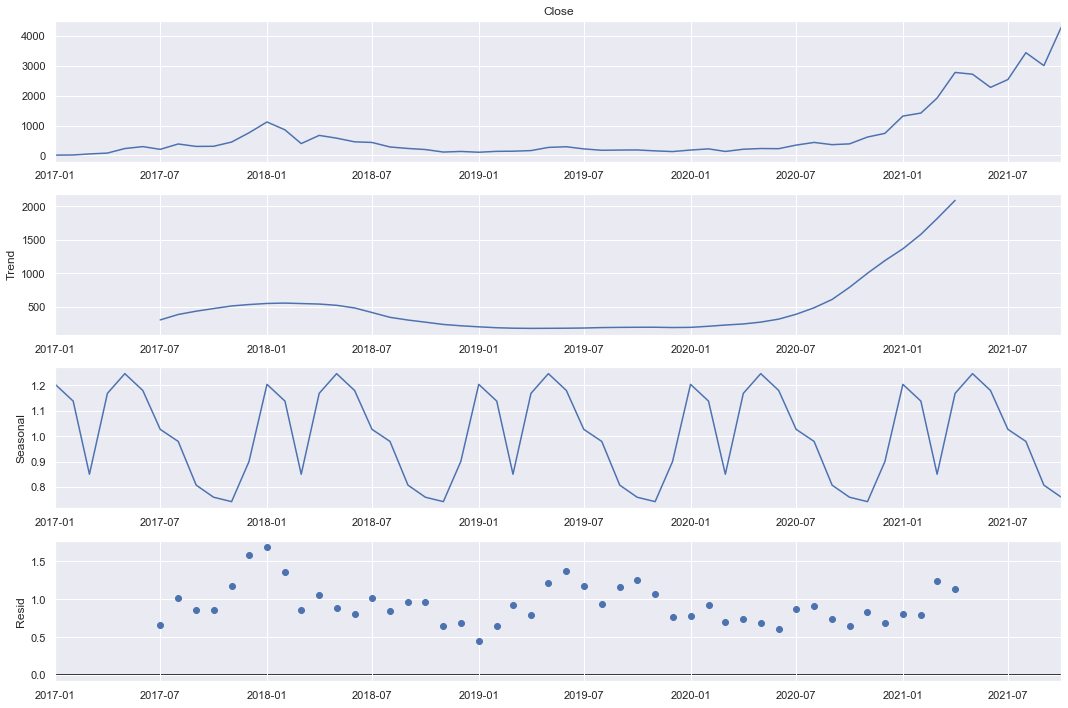

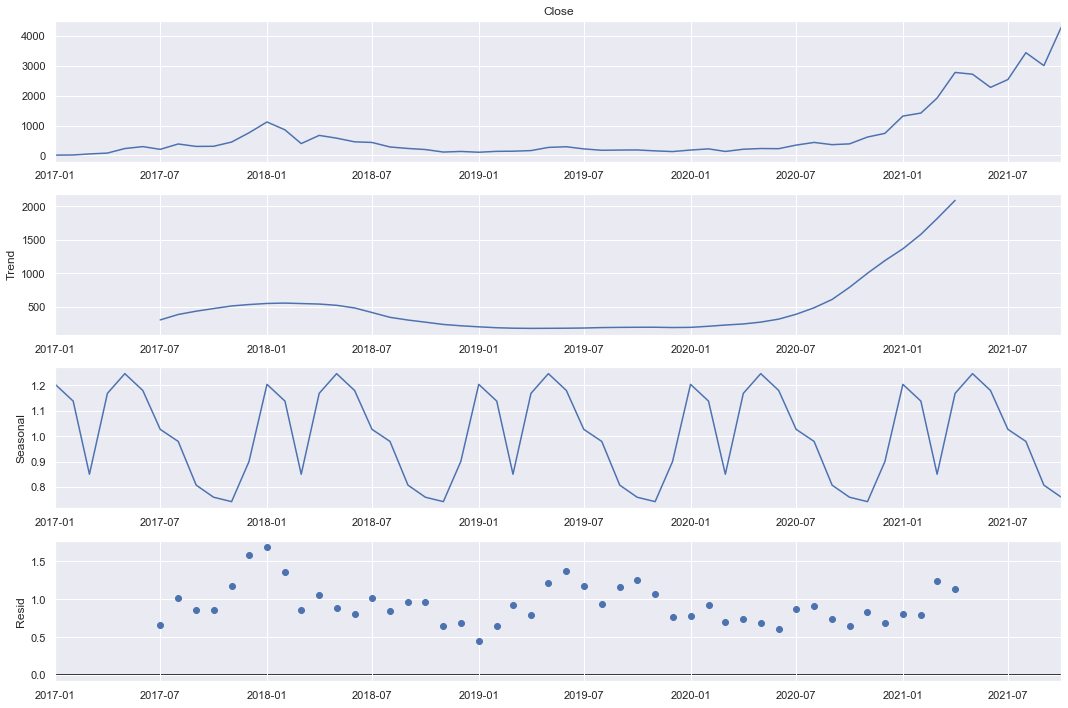

In [8]:
results = seasonal_decompose(ETHoct_df['Close'],model ='multiplicative',period=12)
plt.rcParams.update({'figure.figsize': (15,10)})
results.plot()

In [9]:
#Arima
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function to ETH dataset
stepwise_fit = auto_arima(ETHoct_df['Close'], start_p = 0, start_q = 0,
max_p = 4, max_q = 4, m = 12,
start_P = 0, seasonal = True,
d = None, D = 1, trace = True,
error_action ='ignore', # we don't want to know if an order does not work
suppress_warnings = True, # we don't want convergence warnings
stepwise = True)# set to stepwise

# To print the summary
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[12]             : AIC=666.041, Time=0.08 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=665.294, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=655.189, Time=0.06 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=641.784, Time=0.08 sec
 ARIMA(0,2,1)(0,1,0)[12]             : AIC=640.721, Time=0.03 sec
 ARIMA(0,2,1)(1,1,0)[12]             : AIC=641.949, Time=0.07 sec
 ARIMA(0,2,1)(1,1,1)[12]             : AIC=643.772, Time=0.13 sec
 ARIMA(1,2,1)(0,1,0)[12]             : AIC=640.816, Time=0.05 sec
 ARIMA(0,2,2)(0,1,0)[12]             : AIC=640.305, Time=0.04 sec
 ARIMA(0,2,2)(1,1,0)[12]             : AIC=641.064, Time=0.09 sec
 ARIMA(0,2,2)(0,1,1)[12]             : AIC=641.007, Time=0.09 sec
 ARIMA(0,2,2)(1,1,1)[12]             : AIC=642.984, Time=0.15 sec
 ARIMA(1,2,2)(0,1,0)[12]             : AIC=641.898, Time=0.11 sec
 ARIMA(0,2,3)(0,1,0)[12]             : AIC=642.038, Time=0.07 sec
 ARIMA(1,2,3)(0,1,0)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   58
Model:             SARIMAX(0, 2, 2)x(0, 1, [], 12)   Log Likelihood                -317.152
Date:                             Sun, 12 Dec 2021   AIC                            640.305
Time:                                     21:25:58   BIC                            645.657
Sample:                                          0   HQIC                           642.290
                                              - 58                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1302      0.149     -7.560      0.000      -1.423      -0.837
ma.L2          0.2703      0.136      1.983      0.047       0.003       0.538
sigma2      1.038e+05    1.7e+04      6.088      0.000    7.04e+04    1.37e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 4.26
Prob(Q):                              0.67   Prob(JB):                         0.12
Heteroskedasticity (H):               2.68   Skew:                             0.45
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Split data into train / test sets
train = ETHoct_df.iloc[:len(ETHoct_df)-12]
test = ETHoct_df.iloc[len(ETHoct_df)-12:] # set one year(12 months) for testing

# Fit a SARIMAX(0, 2, 2)x(0, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['Close'],
order = (0, 2, 2),
seasonal_order =(0, 1, 1, 12))

result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                   46
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -211.311
Date:                              Sun, 12 Dec 2021   AIC                            430.621
Time:                                      21:25:58   BIC                            436.484
Sample:                                  01-01-2017   HQIC                           432.565
                                       - 10-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8426      0.266     -3.166      0.002      -1.364      -0.321
ma.L2         -0.0443      0.205     -0.217      0.829      -0.446       0.357
ma.S.L12      -0.9957     74.261     -0.013      0.989    -146.545     144.554
sigma2      1.958e+04   1.45e+06      0.013      0.989   -2.83e+06    2.87e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.98   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.32   Prob(JB):                         0.26
Heteroskedasticity (H):               0.34   Skew:                             0.71
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

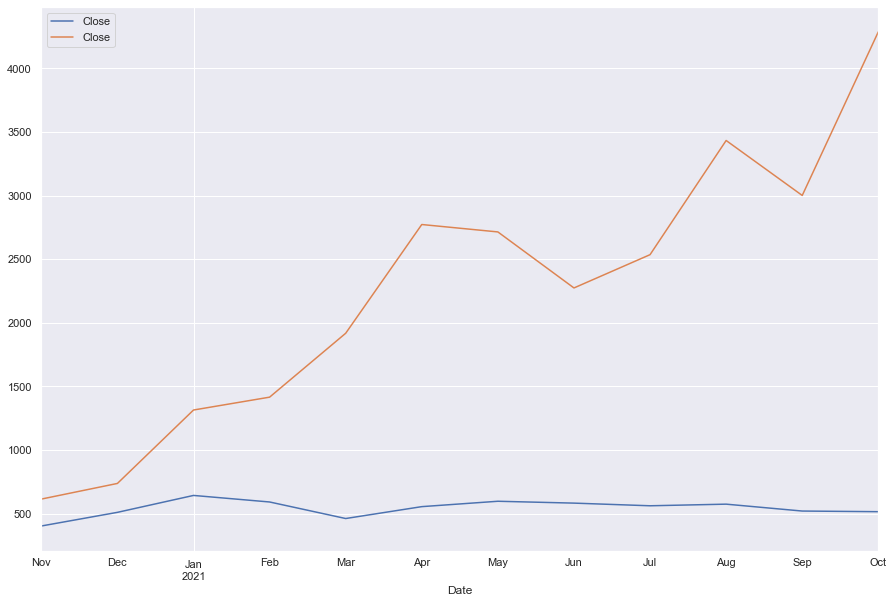

In [11]:
#Predictions of ARIMA Model agains the Test set
start = len(train)
end = len(train) + len(test) - 1

# Predictions for one-year against the test set
predictions = result.predict(start, end,typ = 'levels').rename("Close")

# plot predictions and actual values
predictions.plot(legend = True)
test['Close'].plot(legend = True)


In [12]:
#Evaluate the model using MSE and RMSE
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
rmse(test["Close"], predictions)

2001.3266349852258

In [13]:
# Calculate mean squared error
mean_squared_error(test["Close"], predictions)

4005308.2999012875

Text(0, 0.5, 'Closing Amount (USD)')

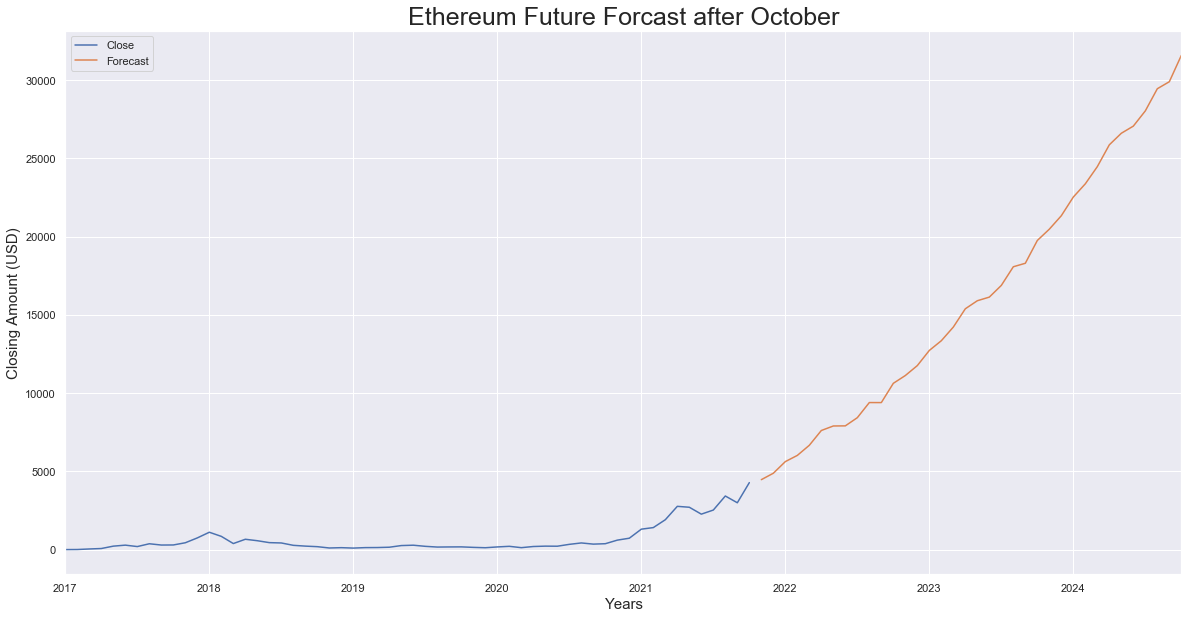

In [15]:
# Train the model on the full dataset
model = model = SARIMAX(ETHoct_df['Close'],order = (0, 2, 2),seasonal_order =(0, 1, 1, 12))
result = model.fit()

# Forecast for the next 3 years
forecast = result.predict(start = len(ETHoct_df),end = (len(ETHoct_df)-1) + 3 * 12,typ = 'levels').rename('Forecast')

# Plot the forecast values
ETHoct_df['Close'].plot(figsize = (20, 10), legend = True)
forecast.plot(legend = True)
plt.title("Ethereum Future Forcast after October", fontsize = 25)
plt.xlabel('Years',fontsize=15)
plt.ylabel('Closing Amount (USD)',fontsize=15)